In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
from itertools import groupby
import music21 as m21
import pandas as pd
import numpy as np
import csv

# List of movements of St Matthew Passion

In [ ]:

bwv244_list = ['bach/bwv244.3.mxl','bach/bwv244.10.mxl','bach/bwv244.15.mxl','bach/bwv244.17.mxl',\
               'bach/bwv244.25.mxl','bach/bwv244.29-a.mxl','bach/bwv244.32.mxl','bach/bwv244.37.mxl',\
               'bach/bwv244.40.mxl','bach/bwv244.44.mxl','bach/bwv244.46.mxl',\
               'bach/bwv244.54.mxl','bach/bwv244.62.mxl']

# Important function

In [ ]:
### Code adapted from 
### https://colab.research.google.com/github/cpmpercussion/creative-prediction/blob/master/notebooks/3-zeldic-musical-RNN.ipynb
### It is modified to have transpose function

MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
def streamToNoteArray(stream, transpose=False):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part 0, transpose the notes
    if transpose:
      k = stream.analyze('key')
      # print("Expected key: ",k)
      # print("Alternative key(s):")
      # for analysis in k.alternateInterpretations:
      #   if (analysis.correlationCoefficient > 0.5):
      #       print(analysis)
      i = m21.interval.Interval(k.tonic, m21.pitch.Pitch('D'))
      stream = stream.transpose(i)

    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, m21.note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, m21.chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

# Original sequence extracting

## Soprano

In [ ]:
# Get a list of pitch arrays
bwv244_sop_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  sop = piece.parts[0]
  pitch_array = streamToNoteArray(sop)
  bwv244_sop_pitch_arrays.append(pitch_array)

# Check the length of each part in the list
for i in bwv244_sop_pitch_arrays:
  print(i.shape)

# Concatenate the arrays into one and get some info about the array
bwv244_sop_pitch_whole = np.concatenate(np.array(bwv244_sop_pitch_arrays))
print("Number of notes:")
print(bwv244_sop_pitch_whole.shape)
bwv244_sop_pitch_whole_df = pd.DataFrame(bwv244_sop_pitch_whole)
print("Notes that do appear:")
unique_sop, counts_sop = np.unique(bwv244_sop_pitch_whole, return_counts=True)
print(unique_sop)
print("with occurence:")
print(counts_sop)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_sop))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 60  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79 128 129]
with occurence:
[   2    2    2   16   14   26   45   19   70   37   75   57   72   95
   31   42   15   13    7   13 1952]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127]


## Alto

In [ ]:
bwv244_alto_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  alto = piece.parts[1]
  pitch_array = streamToNoteArray(alto)
  bwv244_alto_pitch_arrays.append(pitch_array)

for i in bwv244_alto_pitch_arrays:
  print(i.shape)

bwv244_alto_pitch_whole = np.concatenate(np.array(bwv244_alto_pitch_arrays))
print("Number of notes:")
print(bwv244_alto_pitch_whole.shape)
bwv244_alto_pitch_whole_df = pd.DataFrame(bwv244_alto_pitch_whole)
print("Notes that do appear:")
unique_alto, counts_alto = np.unique(bwv244_alto_pitch_whole, return_counts=True)
print(unique_alto)
print("with occurence:")
print(counts_alto)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_alto))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74 128 129]
with occurence:
[   1    2    2   10   25   15   71   53   99   73  100   77   60   75
   22   35   11    3    1   13 1857]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  56  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127]


## Tenor

In [ ]:
bwv244_tenor_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  tenor = piece.parts[2]
  pitch_array = streamToNoteArray(tenor)
  bwv244_tenor_pitch_arrays.append(pitch_array)

for i in bwv244_tenor_pitch_arrays:
  print(i.shape)

bwv244_tenor_pitch_whole = np.concatenate(np.array(bwv244_tenor_pitch_arrays))
print("Number of notes:")
print(bwv244_tenor_pitch_whole.shape)
bwv244_tenor_pitch_whole_df = pd.DataFrame(bwv244_tenor_pitch_whole)
print("Notes that do appear:")
unique_tenor, counts_tenor = np.unique(bwv244_tenor_pitch_whole, return_counts=True)
print(unique_tenor)
print("with occurence:")
print(counts_tenor)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_tenor))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69 128 129]
with occurence:
[   1    5   14   12   45   31   94   76   90   77   71   93   29   59
   20   26   13    3    2   13 1831]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127]


## Bass

In [ ]:
bwv244_bass_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  bass = piece.parts[3]
  pitch_array = streamToNoteArray(bass)
  bwv244_bass_pitch_arrays.append(pitch_array)

for i in bwv244_bass_pitch_arrays:
  print(i.shape)

bwv244_bass_pitch_whole = np.concatenate(np.array(bwv244_bass_pitch_arrays))
print("Number of notes:")
print(bwv244_bass_pitch_whole.shape)
bwv244_bass_pitch_whole_df = pd.DataFrame(bwv244_bass_pitch_whole)
print("Notes that do appear:")
unique_bass, counts_bass = np.unique(bwv244_bass_pitch_whole, return_counts=True)
print(unique_bass)
print("with occurence:")
print(counts_bass)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_bass))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64 128 129]
with occurence:
[   1    2    2    4   11    9   29   22   34   35   34   70   38   76
   48   72   64   44   62   20   36   10    6    5    1    1   13 1856]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  39  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127]


## whole analysis

In [ ]:
# Pool all together to check the distribution of pitches
all_notes = np.concatenate((bwv244_sop_pitch_whole,bwv244_alto_pitch_whole, \
                            bwv244_tenor_pitch_whole, bwv244_bass_pitch_whole))
print("Number of notes:")
print(all_notes.shape)
all_notes_df = pd.DataFrame(all_notes)
print("Notes that do appear:")
unique, counts = np.unique(all_notes, return_counts=True)
print(unique)
print("with occurence:")
print(counts)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique))

Number of notes:
(10420,)
Notes that do appear:
[ 38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79 128 129]
with occurence:
[   1    2    2    4   11    9   29   22   34   35   34   70   39   81
   62   84  110   75  158   98  136  114   92  171   85  175  107  152
  135   82  147   59  110   68   75   96   31   42   15   13    7   52
 7496]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  39  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]


Plot the relative occurences of each note:


Text(0.5, 1.0, 'Original')

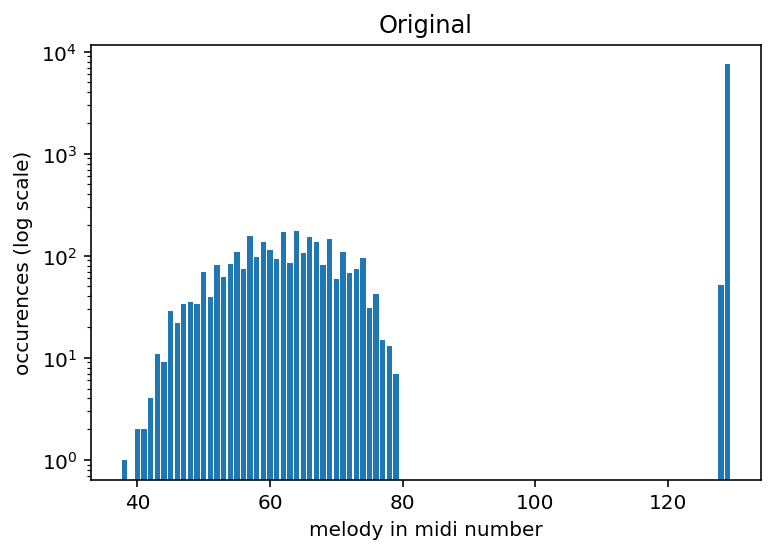

In [ ]:
print("Plot the relative occurences of each note:")
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('dark_background')
plt.bar(unique, counts)
plt.yscale('log')
plt.xlabel('melody in midi number')
plt.ylabel('occurences (log scale)')
plt.title('Original')

In [ ]:
pitch_original = unique.tolist()
pitch_sym = [i for i in range(len(unique))]
sym_dict = dict(zip(pitch_original, pitch_sym))

In [ ]:
sym_dict

{38: 0,
 40: 1,
 41: 2,
 42: 3,
 43: 4,
 44: 5,
 45: 6,
 46: 7,
 47: 8,
 48: 9,
 49: 10,
 50: 11,
 51: 12,
 52: 13,
 53: 14,
 54: 15,
 55: 16,
 56: 17,
 57: 18,
 58: 19,
 59: 20,
 60: 21,
 61: 22,
 62: 23,
 63: 24,
 64: 25,
 65: 26,
 66: 27,
 67: 28,
 68: 29,
 69: 30,
 70: 31,
 71: 32,
 72: 33,
 73: 34,
 74: 35,
 75: 36,
 76: 37,
 77: 38,
 78: 39,
 79: 40,
 128: 41,
 129: 42}

In [ ]:
# 51-59, 60-71, 71-79, 128, 129
note_sym = [2]+[i for i in range(4,12)]+[i for i in range(12)]+[i for i in range(12)]+[i for i in range(8)]+[12,13]
note_dict = dict(zip(pitch_original, note_sym))

In [ ]:
note_dict

{38: 2,
 40: 4,
 41: 5,
 42: 6,
 43: 7,
 44: 8,
 45: 9,
 46: 10,
 47: 11,
 48: 0,
 49: 1,
 50: 2,
 51: 3,
 52: 4,
 53: 5,
 54: 6,
 55: 7,
 56: 8,
 57: 9,
 58: 10,
 59: 11,
 60: 0,
 61: 1,
 62: 2,
 63: 3,
 64: 4,
 65: 5,
 66: 6,
 67: 7,
 68: 8,
 69: 9,
 70: 10,
 71: 11,
 72: 0,
 73: 1,
 74: 2,
 75: 3,
 76: 4,
 77: 5,
 78: 6,
 79: 7,
 128: 12,
 129: 13}

In [ ]:
# Downsize the symbol so that only count the pitches that appear
pitch_series1 = list(map(sym_dict.get, bwv244_sop_pitch_whole))
pitch_series2 = list(map(sym_dict.get, bwv244_alto_pitch_whole))
pitch_series3 = list(map(sym_dict.get, bwv244_tenor_pitch_whole))
pitch_series4 = list(map(sym_dict.get, bwv244_bass_pitch_whole))

# Write the 4 variables into one single csv
with open('bwv244.csv', mode='w') as csv_file:
  writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  for i in range(len(pitch_series1)):
    writer.writerow([pitch_series1[i],pitch_series2[i],pitch_series3[i],pitch_series4[i]])

In [ ]:
# Further Downsize the symbol to 14 note types
pitch_series12 = list(map(note_dict.get, bwv244_sop_pitch_whole))
pitch_series22 = list(map(note_dict.get, bwv244_alto_pitch_whole))
pitch_series32 = list(map(note_dict.get, bwv244_tenor_pitch_whole))
pitch_series42 = list(map(note_dict.get, bwv244_bass_pitch_whole))

# Write the 4 variables into one single csv
with open('bwv244_notes.csv', mode='w') as csv_file:
  writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  for i in range(len(pitch_series12)):
    writer.writerow([pitch_series12[i],pitch_series22[i],pitch_series32[i],pitch_series42[i]])

# Sequence extracting after transposing to D

## Soprano

In [ ]:
bwv244_sop_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  sop = piece.parts[0]
  pitch_array = streamToNoteArray(sop, transpose=True)
  bwv244_sop_pitch_arrays.append(pitch_array)

for i in bwv244_sop_pitch_arrays:
  print(i.shape)

bwv244_sop_pitch_whole = np.concatenate(np.array(bwv244_sop_pitch_arrays))
print("Number of notes:")
print(bwv244_sop_pitch_whole.shape)
bwv244_sop_pitch_whole_df = pd.DataFrame(bwv244_sop_pitch_whole)
print("Notes that do appear:")
unique_sop, counts_sop = np.unique(bwv244_sop_pitch_whole, return_counts=True)
print(unique_sop)
print("with occurence:")
print(counts_sop)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_sop))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 55  57  58  59  60  61  62  64  65  66  67  69  70  71  72  73  74  76
  77  79 128 129]
with occurence:
[   6   32   17    3   25    7   75   96   41   77   79   73   13   14
   13    6   22   21   18    2   13 1952]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  56  63  68  75  78  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]


## Alto

In [ ]:
bwv244_alto_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  alto = piece.parts[1]
  pitch_array = streamToNoteArray(alto, transpose=True)
  bwv244_alto_pitch_arrays.append(pitch_array)

for i in bwv244_alto_pitch_arrays:
  print(i.shape)

bwv244_alto_pitch_whole = np.concatenate(np.array(bwv244_alto_pitch_arrays))
print("Number of notes:")
print(bwv244_alto_pitch_whole.shape)
bwv244_alto_pitch_whole_df = pd.DataFrame(bwv244_alto_pitch_whole)
print("Notes that do appear:")
unique_alto, counts_alto = np.unique(bwv244_alto_pitch_whole, return_counts=True)
print(unique_alto)
print("with occurence:")
print(counts_alto)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_alto))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 50  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74 128 129]
with occurence:
[   1    4   25    2   28    2   47   11   19   18   29  122   10   97
   26  114   92   12   58    4    9    1    2    2   13 1857]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  51  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127]


## Tenor

In [ ]:
bwv244_tenor_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  tenor = piece.parts[2]
  pitch_array = streamToNoteArray(tenor, transpose=True)
  bwv244_tenor_pitch_arrays.append(pitch_array)

for i in bwv244_tenor_pitch_arrays:
  print(i.shape)

bwv244_tenor_pitch_whole = np.concatenate(np.array(bwv244_tenor_pitch_arrays))
print("Number of notes:")
print(bwv244_tenor_pitch_whole.shape)
bwv244_tenor_pitch_whole_df = pd.DataFrame(bwv244_tenor_pitch_whole)
print("Notes that do appear:")
unique_tenor, counts_tenor = np.unique(bwv244_tenor_pitch_whole, return_counts=True)
print(unique_tenor)
print("with occurence:")
print(counts_tenor)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_tenor))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 43  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  64  65 128 129]
with occurence:
[   2    9    4   11   11   26   84    4  108   60   76  127   12  136
    5   40   22    4   14    5    1   13 1831]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  44  63  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127]


## Bass

In [ ]:
bwv244_bass_pitch_arrays = []
for bwv_part in bwv244_list:
  piece = m21.corpus.parse(bwv_part)
  bass = piece.parts[3]
  pitch_array = streamToNoteArray(bass, transpose=True)
  bwv244_bass_pitch_arrays.append(pitch_array)

for i in bwv244_bass_pitch_arrays:
  print(i.shape)

bwv244_bass_pitch_whole = np.concatenate(np.array(bwv244_bass_pitch_arrays))
print("Number of notes:")
print(bwv244_bass_pitch_whole.shape)
bwv244_bass_pitch_whole_df = pd.DataFrame(bwv244_bass_pitch_whole)
print("Notes that do appear:")
unique_bass, counts_bass = np.unique(bwv244_bass_pitch_whole, return_counts=True)
print(unique_bass)
print("with occurence:")
print(counts_bass)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique_bass))

(177,)
(193,)
(193,)
(257,)
(193,)
(209,)
(177,)
(193,)
(257,)
(193,)
(177,)
(193,)
(193,)
Number of notes:
(2605,)
Notes that do appear:
[ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62 128 129]
with occurence:
[   5    1    1    6    5   29    1   22   27   22   41   12   89   29
   47   28   32   87   10   64   30   44   31   12   36    6   12    3
    1    3   13 1856]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127]


## whole analysis

In [ ]:
all_notes2 = np.concatenate((bwv244_sop_pitch_whole,bwv244_alto_pitch_whole, \
                            bwv244_tenor_pitch_whole, bwv244_bass_pitch_whole))
print("Number of notes:")
print(all_notes2.shape)
all_notes2_df = pd.DataFrame(all_notes2)
print("Notes that do appear:")
unique2, counts2 = np.unique(all_notes2, return_counts=True)
print(unique2)
print("with occurence:")
print(counts2)
print("Notes that don't appear:")
print(np.setdiff1d(np.arange(0,129),unique2))

Number of notes:
(10420,)
Notes that do appear:
[ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  76  77  79 128 129]
with occurence:
[   5    1    1    6    5   29    1   22   27   22   43   12   98   33
   58   39   58  172   14  176  115  122  192   26  251   39   74   68
   41  214   10  198   68  191  171   12  131   17   23   14    8   24
   21   18    2   52 7496]
Notes that don't appear:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  75  78  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127]


Plot the relative occurences of each note:


Text(0.5, 1.0, 'Transposed to D')

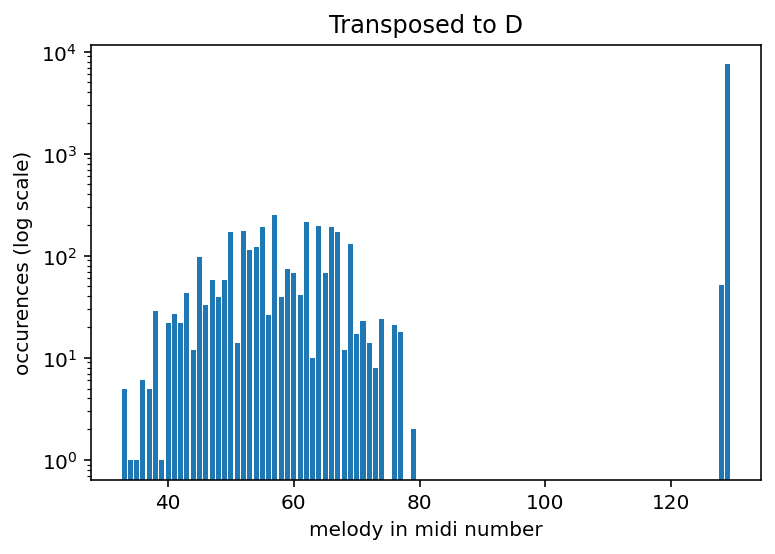

In [ ]:
print("Plot the relative occurences of each note:")
import matplotlib.pyplot as plt
%matplotlib inline

#plt.style.use('dark_background')
plt.bar(unique2, counts2)
plt.yscale('log')
plt.xlabel('melody in midi number')
plt.ylabel('occurences (log scale)')
plt.title('Transposed to D')

In [ ]:
unique2.shape

(47,)

In [ ]:
pitch_original2 = unique2.tolist()
pitch_sym2 = [i for i in range(47)]
sym_dict2 = dict(zip(pitch_original2, pitch_sym2))

In [ ]:
sym_dict2

{33: 0,
 34: 1,
 35: 2,
 36: 3,
 37: 4,
 38: 5,
 39: 6,
 40: 7,
 41: 8,
 42: 9,
 43: 10,
 44: 11,
 45: 12,
 46: 13,
 47: 14,
 48: 15,
 49: 16,
 50: 17,
 51: 18,
 52: 19,
 53: 20,
 54: 21,
 55: 22,
 56: 23,
 57: 24,
 58: 25,
 59: 26,
 60: 27,
 61: 28,
 62: 29,
 63: 30,
 64: 31,
 65: 32,
 66: 33,
 67: 34,
 68: 35,
 69: 36,
 70: 37,
 71: 38,
 72: 39,
 73: 40,
 74: 41,
 76: 42,
 77: 43,
 79: 44,
 128: 45,
 129: 46}

In [ ]:
# 33-35, 36-47, 48-59, 60-71, 72-74,76,77,79,128,129
note_sym2 = [i for i in range(9,12)]+[i for i in range(12)]+[i for i in range(12)]+ [i for i in range(12)] + [i for i in range(3)]+[4,5,7,12,13]
print(len(note_sym2))
note_dict2 = dict(zip(pitch_original2, note_sym2))

47


In [ ]:
note_dict2

{33: 9,
 34: 10,
 35: 11,
 36: 0,
 37: 1,
 38: 2,
 39: 3,
 40: 4,
 41: 5,
 42: 6,
 43: 7,
 44: 8,
 45: 9,
 46: 10,
 47: 11,
 48: 0,
 49: 1,
 50: 2,
 51: 3,
 52: 4,
 53: 5,
 54: 6,
 55: 7,
 56: 8,
 57: 9,
 58: 10,
 59: 11,
 60: 0,
 61: 1,
 62: 2,
 63: 3,
 64: 4,
 65: 5,
 66: 6,
 67: 7,
 68: 8,
 69: 9,
 70: 10,
 71: 11,
 72: 0,
 73: 1,
 74: 2,
 76: 4,
 77: 5,
 79: 7,
 128: 12,
 129: 13}

In [ ]:
pitch_series21 = list(map(sym_dict2.get, bwv244_sop_pitch_whole))
pitch_series22 = list(map(sym_dict2.get, bwv244_alto_pitch_whole))
pitch_series23 = list(map(sym_dict2.get, bwv244_tenor_pitch_whole))
pitch_series24 = list(map(sym_dict2.get, bwv244_bass_pitch_whole))

with open('bwv244_D.csv', mode='w') as csv_file:
  writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  for i in range(len(pitch_series21)):
    writer.writerow([pitch_series21[i],pitch_series22[i],pitch_series23[i],pitch_series24[i]])

In [ ]:
pitch_series212 = list(map(note_dict2.get, bwv244_sop_pitch_whole))
pitch_series222 = list(map(note_dict2.get, bwv244_alto_pitch_whole))
pitch_series232 = list(map(note_dict2.get, bwv244_tenor_pitch_whole))
pitch_series242 = list(map(note_dict2.get, bwv244_bass_pitch_whole))

with open('bwv244_D_notes.csv', mode='w') as csv_file:
  writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  for i in range(len(pitch_series212)):
    writer.writerow([pitch_series212[i],pitch_series222[i],pitch_series232[i],pitch_series242[i]])